In [16]:
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

In [17]:
class Linear:
    def __init__(self, inodes, onodes, opt):
        self.w = np.random.normal(scale=1,
                                  size=(onodes, inodes),
        ) * np.sqrt(2 / (inodes + onodes))
        self.b = np.zeros(onodes)
        self.accumulated_w = 0.0
        self.accumulated_b = 0.0
        self.accumulated_len = 0
        self.beta1, self.beta2 = 0.9, 0.999
        self.epsilon = 1e-08
        # self.weight_decay=0.0001
        self.weight_decay = 0.0
        self.first_moment_w, self.second_moment_w = \
            np.zeros((onodes, inodes)),\
            np.zeros((onodes, inodes))
        self.first_moment_b, self.second_moment_b = \
            np.zeros((onodes)),\
            np.zeros((onodes))
        self.OPT = opt
        self.accumulated_bt_w = 0.0
        self.accumulated_bt_b = 0.0
        self.mu = 0.9
        self.state_sum_w = 0.0
        self.state_sum_b = 0.0
        self.eps = 1e-10
    def __call__(self, x):
        self.x = x
        return np.dot(self.w, x)+self.b
    def backward(self, grad, lr, update):
        dw = np.outer(grad, self.x)
        db = grad
        self.accumulated_len += 1
        self.accumulated_w += dw
        self.accumulated_b += db
        if update:
            match self.OPT:
                case 'Adam':
                    g_w = self.accumulated_w/self.accumulated_len
                    g_b = self.accumulated_b/self.accumulated_len
                    self.w -= self.weight_decay*self.w 
                    self.b -= self.weight_decay*self.b
                    self.first_moment_w = self.beta1*self.first_moment_w+(1-self.beta1)*g_w
                    self.first_moment_b = self.beta1*self.first_moment_b+(1-self.beta1)*g_b
                    self.second_moment_w = self.beta2*self.second_moment_w+(1-self.beta2)*g_w**2
                    self.second_moment_b = self.beta2*self.second_moment_b+(1-self.beta2)*g_b**2
                    m_w = self.first_moment_w/(1-self.beta1)
                    m_b = self.first_moment_b/(1-self.beta1)
                    v_w = self.second_moment_w/(1-self.beta2)
                    v_b = self.second_moment_b/(1-self.beta2)
                    self.w -= lr*m_w/(np.sqrt(v_w)+self.epsilon)
                    self.b -= lr*m_b/(np.sqrt(v_b)+self.epsilon)
                case 'SGD':
                    self.w -= lr*self.accumulated_w/self.accumulated_len
                    self.b -= lr*self.accumulated_b/self.accumulated_len
                case 'NGD':
                    g_w = self.accumulated_w/self.accumulated_len
                    g_b = self.accumulated_b/self.accumulated_len
                    self.accumulated_bt_w = self.mu*self.accumulated_bt_w + g_w
                    self.accumulated_bt_b = self.mu*self.accumulated_bt_b + g_b 
                    g_w += self.mu*self.accumulated_bt_w
                    g_b += self.mu*self.accumulated_bt_b
                    self.w -= lr*g_w
                    self.b -= lr*g_b
                case 'Adagrad':
                    g_w = self.accumulated_w/self.accumulated_len
                    g_b = self.accumulated_b/self.accumulated_len
                    self.state_sum_w += g_w**2
                    self.state_sum_b += g_b**2
                    self.w -= lr * g_w / (np.sqrt(self.state_sum_w)+self.eps)
                    self.b -= lr * g_b / (np.sqrt(self.state_sum_b)+self.eps)
            self.zero_grad()
        return np.dot(grad, self.w)
    def zero_grad(self):
        self.accumulated_w = 0.0
        self.accumulated_b = 0.0
        self.accumulated_len = 0
class ReLu:
    def __call__(self, x):
        self.x = x
        return np.maximum(x, 0)
    def backward(self, grad):
        grad[self.x < 0] = 0
        return grad
class Softmax:
    def __call__(self, x):
        self.p = np.exp(x) / np.sum(np.exp(x))
        return self.p 
    def backward(self, grad):
        jacobian = np.zeros((np.size(grad), np.size(grad)))
        for i in range(len(jacobian)):
            for j in range(len(jacobian)):
                if i == j:
                    jacobian[i][j] = self.p[i] * (1 - self.p[j])
                else:
                    jacobian[i][j] = -self.p[i] * self.p[j]
        return grad @ jacobian


In [18]:





class L2Loss:
    def __call__(self, y, p) :
        self.p = p
        self.y = y
        return np.sum((y-p)**2)
    def backward(self):
        return (self.p-self.y)*2
class CrossEntropy:
    def __call__(self, y, p):
        self.p = p
        self.y = y 
        return -np.sum(y*np.log(p))
    def backward(self):
        return -self.y/self.p 
class KLDivLoss:
    def __call__(self, y, p):
        self.p = p
        self.y = y 
        res = y*(np.log(y/p))
        return np.sum(np.where(np.isnan(res), 0, res))
    def backward(self):
        return -self.y/self.p
    

In [19]:
class NN:
    def __init__(self, arch):
        self.arch = arch 
    def __call__(self, x):
        p = None
        for layer in self.arch:
            if not (p is None):
                p = layer[0](p)
                p = layer[1](p)
            else:
                p = layer[0](x)
                p = layer[1](p)
        return p
    def backward(self, grad, lr, update):
        for layer in self.arch[::-1]:
            grad = layer[1].backward(grad)
            grad = layer[0].backward(grad, lr, update)
    def zero_grad(self):
        for layer in self.arch[::-1]:
            grad = layer[0].zero_grad()
        

In [20]:
ds = MNIST(
    './data/train',
    True,
    lambda img: np.array(np.asarray(img).flatten())/256,
    lambda y: np.array([1 if i==y else 0 for i in range(10)]),
    download=False
)
ds_test = MNIST(
    './data/test',
    False,
    lambda img: np.array(np.asarray(img).flatten())/256,
    lambda y: np.array([1 if i==y else 0 for i in range(10)]),
    download=False
)
ds_train = Subset(ds, range(0, 55000))
ds_val = Subset(ds, range(55000, 60000))
batch_size = 64
train_data = DataLoader(ds_train, batch_size, True, drop_last=True)
test_data = DataLoader(ds_test, None, False)
val_data = DataLoader(ds_val, None, False)


In [21]:
def save_plot(x, name, labels):
    plt.figure(figsize=(10, 7))
    plt.plot(
        x, linestyle='-', 
        label=labels
    )
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend()
    plt.savefig(f"{name}.png")

In [22]:
def multi_train(models, img, target, loss_functions, lr, batch_counter):
    losss = []
    for model, loss_function in zip(models, loss_functions):
        pred = model(img)
        loss = loss_function(target, pred)
        losss.append(loss)
        batch_counter += 1
        if batch_counter != batch_size:
            model.backward(loss_function.backward(), lr, False)
        else:
            model.backward(loss_function.backward(), lr, True)
    return losss
def multi_val(models, img, target):
    accs = []
    for model in models:
        pred = model(img)
        accs.append(1 if np.argmax(pred) == np.argmax(target) else 0)
    return accs

In [23]:
def train_one_epoch(models, data, val, loss_functions, lr):
    losses = [[] for _ in models]
    counter = 0
    true = [0 for _ in models]
    print("Train")
    for imgs, targets in tqdm(data):
        batch_counter = 0
        for i in range(len(models)):
            models[i].zero_grad()
            
        for img, target in zip(imgs, targets):
            img, target = np.asarray(img), np.asarray(target)
            batch_counter+=1
            losss = multi_train(models, img, target, loss_functions, lr, batch_counter)
            for i in range(len(losss)):
                losses[i].append(losss[i])
            
    res_loss = [np.mean(loss) for loss in losses]
    print(f"Loss: {res_loss}")
    print("Validate")
    for img, target in tqdm(val):
        img, target = np.asarray(img), np.asarray(target)
        accs = multi_val(models, img, target)
        for i in range(len(accs)):
            true[i] += accs[i]
        counter +=1
    res_acc = [model_true/counter for model_true in true]
    print(f"Accuracy: {res_acc}")
    return res_loss, res_acc

        
        

In [24]:
models = [
    NN([
        [Linear(784, 1024, 'SGD'), ReLu()],
        [Linear(1024, 256, 'SGD'), ReLu()],
        [Linear(256, 64, 'SGD'), ReLu()],
        [Linear(64, 10, 'SGD'), Softmax()],
    ]),
    NN([
        [Linear(784, 1024, 'NGD'), ReLu()],
        [Linear(1024, 256, 'NGD'), ReLu()],
        [Linear(256, 64, 'NGD'), ReLu()],
        [Linear(64, 10, 'NGD'), Softmax()],
    ]),
    NN([
        [Linear(784, 1024, 'Adagrad'), ReLu()],
        [Linear(1024, 256, 'Adagrad'), ReLu()],
        [Linear(256, 64, 'Adagrad'), ReLu()],
        [Linear(64, 10, 'Adagrad'), Softmax()],
    ]),
    NN([
        [Linear(784, 1024, 'Adam'), ReLu()],
        [Linear(1024, 256, 'Adam'), ReLu()],
        [Linear(256, 64, 'Adam'), ReLu()],
        [Linear(64, 10, 'Adam'), Softmax()],
    ])
]
loss_function = [CrossEntropy(), CrossEntropy(), CrossEntropy(), CrossEntropy()]
lr = 0.001
num_epochs = 3

In [25]:
losses = [[] for _ in models]
acces = [[] for _ in models]
for i in range(1, num_epochs+1):
    print(f"Epoch {i} of {num_epochs}")
    loss, acc = train_one_epoch(models, train_data, val_data, loss_function, lr)
    for i in range(len(acces)):
        losses[i].append(loss[i])
        acces[i].append(acc[i])

Epoch 1 of 3
Train


100%|██████████| 859/859 [09:06<00:00,  1.57it/s]


Loss: [np.float64(2.051728463590799), np.float64(0.82533272064717), np.float64(0.3317930694498785), np.float64(0.19219817419392604)]
Validate


100%|██████████| 5000/5000 [00:06<00:00, 775.14it/s]


Accuracy: [0.6926, 0.926, 0.9564, 0.974]
Epoch 2 of 3
Train


100%|██████████| 859/859 [09:04<00:00,  1.58it/s]


Loss: [np.float64(1.406535097601811), np.float64(0.3092544614571505), np.float64(0.196688099209607), np.float64(0.07196577647793342)]
Validate


100%|██████████| 5000/5000 [00:06<00:00, 751.30it/s]


Accuracy: [0.8334, 0.9428, 0.9626, 0.976]
Epoch 3 of 3
Train


100%|██████████| 859/859 [09:03<00:00,  1.58it/s]


Loss: [np.float64(0.9089692635502176), np.float64(0.24832363408755853), np.float64(0.1662410426317834), np.float64(0.046291801289537984)]
Validate


100%|██████████| 5000/5000 [00:06<00:00, 745.32it/s]

Accuracy: [0.8752, 0.948, 0.9644, 0.9812]


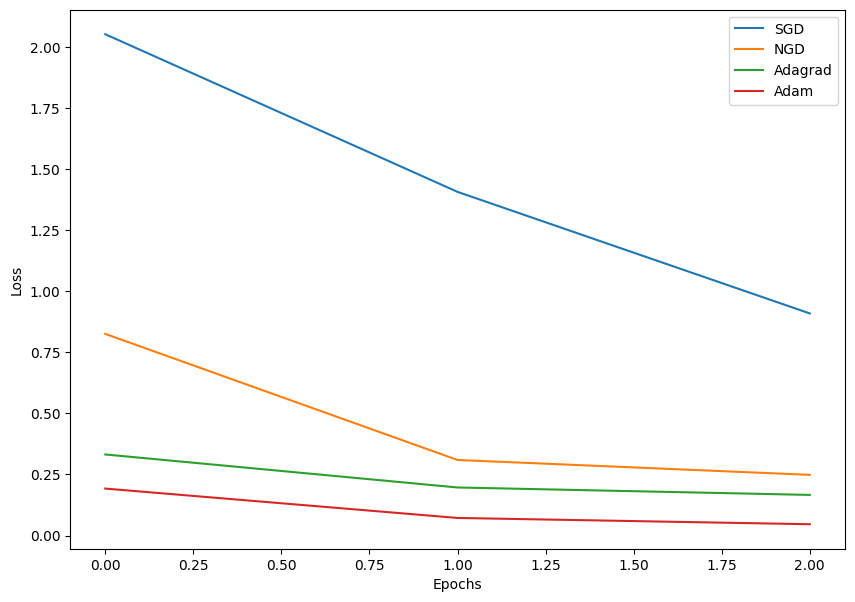

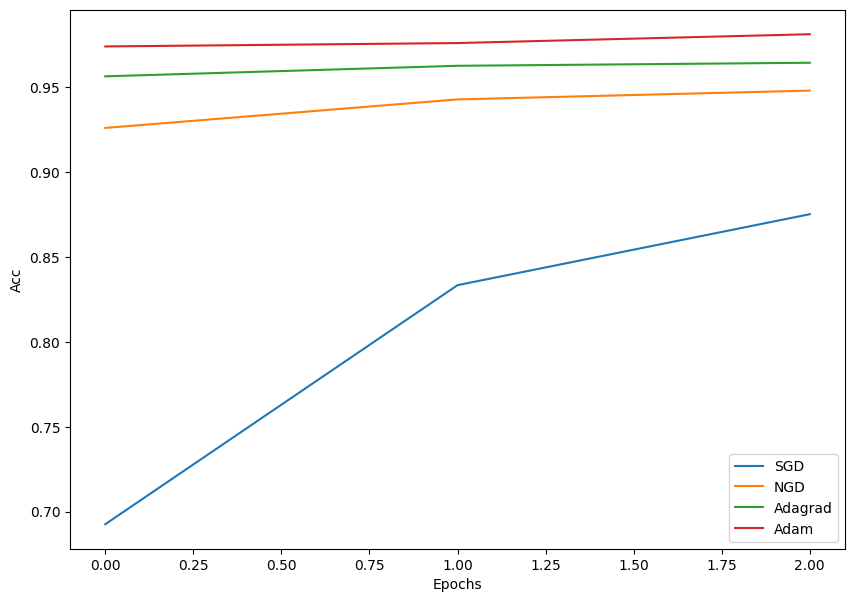

In [26]:
losses = np.asarray(losses).T
acces = np.asarray(acces).T
save_plot(losses, 'Loss', ['SGD', 'NGD', 'Adagrad', 'Adam'])
save_plot(acces, 'Acc', ['SGD', 'NGD', 'Adagrad', 'Adam'])

In [27]:

import pickle
with open(r'backup.pickle', 'wb') as f:
    pickle.dump(models, f)
    
    

In [28]:
# with open(r'backup.pickle', 'rb') as f:
#     models1 = pickle.load(f)

# for img, target in test_data:
#     img, target = np.asarray(img), np.asarray(target)
#     print(np.argmax(models1[0](img)), np.argmax(target))
#     plt.imshow(img.reshape((28, 28)))
#     break

In [29]:
# models1[0]()

In [30]:
# def save_mat(mat, name):
#     classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#     figure = plt.figure()
#     figure.legend(name)
#     axes = figure.add_subplot(111)
    
#     caxes = axes.matshow(mat, interpolation ='nearest')
#     figure.colorbar(caxes)
    
#     axes.set_xticklabels(['']+classes)
#     axes.set_yticklabels(['']+classes)
#     plt.savefig(f"{name}.png")
    

In [31]:
# def calculate_conf_matrix(model, test):
#     conf = np.zeros((len(test), len(test)), dtype=np.int64)
#     for img, target in tqdm(test):
#         img, target = np.asarray(img), np.asarray(target)
#         pred = model(img)
#         j, i = np.argmax(pred), np.argmax(target)
#         conf[i, j] += 1
#     return conf
# mats = []
# for model in models:
#     mats.append(calculate_conf_matrix(model, test_data))


In [32]:
# print(mats[0])
# for mat, name in zip(mats, ['CrossEntropy', 'KLDivLoss', 'L2Loss']):
#     save_mat(mat, name)